In [152]:
import pandas as pd
import geopandas as gpd
import os
import seaborn as sn
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


In [153]:
path_energy = os.path.join("dataset", "energy-cleaned-dataset.csv")
path_geodata = os.path.join("dataset", "world-administrative-boundaries.geojson")
categorical_columns = ["Entity","Continent","Region","iso3"]

In [154]:
df_energy = pd.read_csv(path_energy)
THEME = "plotly_dark"

In [155]:
df_energy

,Entity,Year,Access to electricity (% of population),Access to clean fuels for cooking,Renewable-electricity-generating-capacity-per-capita,Financial flows to developing countries (US $),Renewable energy share in the total final energy consumption (%),Electricity from fossil fuels (TWh),Electricity from nuclear (TWh),Electricity from renewables (TWh),...,gdp_growth,gdp_per_capita,Density (P/Km2),Land Area(Km2),Latitude,Longitude,Continent,Region,iso3,Human Development Index
0,Afghanistan,2000,1.613591,6.2,9.22,20000.0,44.99,0.16,0.0,0.31,...,NaN,NaN,60.0,652230.0,33.939110,67.709953,Asia,Southern Asia,AFG,0.335
1,Afghanistan,2001,4.074574,7.2,8.86,130000.0,45.60,0.09,0.0,0.50,...,NaN,NaN,60.0,652230.0,33.939110,67.709953,Asia,Southern Asia,AFG,0.337
2,Afghanistan,2002,9.409158,8.2,8.47,3950000.0,37.83,0.13,0.0,0.56,...,NaN,179.426579,60.0,652230.0,33.939110,67.709953,Asia,Southern Asia,AFG,0.362
3,Afghanistan,2003,14.738506,9.5,8.09,25970000.0,36.66,0.31,0.0,0.63,...,8.832278,190.683814,60.0,652230.0,33.939110,67.709953,Asia,Southern Asia,AFG,0.376
4,Afghanistan,2004,20.064968,10.9,7.75,NaN,44.24,0.33,0.0,0.56,...,1.414118,211.382074,60.0,652230.0,33.939110,67.709953,Asia,Southern Asia,AFG,0.392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3644,Zimbabwe,2016,42.561730,29.8,62.88,30000.0,81.90,3.50,0.0,3.32,...,0.755869,1464.588957,38.0,390757.0,-19.015438,29.154857,Africa,Eastern Africa,ZWE,0.588
3645,Zimbabwe,2017,44.178635,29.8,62.33,5570000.0,82.46,3.05,0.0,4.30,...,4.709492,1235.189032,38.0,390757.0,-19.015438,29.154857,Africa,Eastern Africa,ZWE,0.594
3646,Zimbabwe,2018,45.572647,29.9,82.53,10000.0,80.23,3.73,0.0,5.46,...,4.824211,1254.642265,38.0,390757.0,-19.015438,29.154857,Africa,Eastern Africa,ZWE,0.602
3647,Zimbabwe,2019,46.781475,30.1,81.40,250000.0,81.50,3.66,0.0,4.58,...,-6.144236,1316.740657,38.0,390757.0,-19.015438,29.154857,Africa,Eastern Africa,ZWE,0.601


In [156]:
serie_na = df_energy.isnull().sum().sort_values(ascending=False)
serie_na.rename('Null Values', inplace=True)

fig_null_data = go.Figure(go.Bar(
    x = serie_na.index,
    y = serie_na,
    text = serie_na,
    textposition = 'auto'
))

fig_null_data.update_layout(
    title = 'Null Values Count',
    xaxis_tickfont_size = 12,
    template = THEME,
)
fig_null_data.show()

In [157]:
missing_values_by_year = df_energy.groupby("Year").apply(lambda x: x.isna().sum().sum())

# Create a line chart
fig_na = px.line(
    x=missing_values_by_year.index,
    y=missing_values_by_year,
    template=THEME,  # Assuming THEME is defined elsewhere
    labels={"x": "Years", "y": "Missing values count"},
    range_y=[0, 400],
    markers=True,
    title="Evolution of missing values over time",
    #color='country', symbol="country"
)

fig_na.show()

In [158]:
def getNaNumber(variable):
    names = df_energy["Entity"].unique()
    value = np.array([df_energy[df_energy["Entity"]==country][variable].isna().sum() for country in names])
    no_data = value[(value == 21)].__len__()
    valide_data = value[(value == 0)].__len__()
    incomplete_data = names.__len__() - valide_data - no_data
    return no_data, incomplete_data, valide_data

values = [[],[],[],[]]
for variable in df_energy.keys():
    nd, id, vd = getNaNumber(variable)
    values[0].append(variable)
    values[1].append(nd)
    values[2].append(id)
    values[3].append(vd)

# print(values)

dic = { key : value for key, value in zip(["Variable","No data", "Incomplete data", "Valide data"], values) }

df_na = pd.DataFrame(dic)
# print(df_na)

df_na.sort_values("No data", ascending=False, inplace=True)
# print(df_na)

for i, ligne in df_na[0:1].iterrows():
    fig = px.pie(ligne,
                names=ligne.index[1:],
                values=ligne.values[1:],
                title=ligne["Variable"],
                template=THEME,
                # color_discrete_sequence=["green","orange","red"],
                color_discrete_map={"No data":"rgb(255,0,0)", "Incomplete data": "orange", "Valide data": "green"},
                )
    fig.show()

### Heatmap of missing values : 
The goal is to make a subplot of a Heatmap which indicate the number of nan for a given region or country and the number for a easier reading. 

We creat the needed dataset for the heatmap 
* on a country
* with only the required values (all except the 'Year' and the 'Entity') present on other axis.


We make the  subplot graph thanks to : 
1. [mixed sub-plot](https://plotly.com/python/mixed-subplots/) documentation
2. [specs of subplot](https://plotly.com/python/subplots/#subplots-types) documentation

In [159]:
def heatmap(df_heatmap : pd.DataFrame  = df_energy, area_type : str = "Continent", area_name : str = "Asia") -> go.Figure :
    """
    This function creat a complexe multi-figure within a heatmap of missing values for the given area_name for all features and an indicator trace.
    :param df_heatmap: The data frame to analyse
    :param area_type: ["Entity", "Continent", "Region", "iso3"]
    :param area_name: ["France", "Europe", "Western Europe", "FRA", ...]
    :return: a figure object of the plotly lib (heatmap + indicator)
    """
    
    ###############
    ## Computation
    ###############
    # The set of var to observe except the one used on other axis
    col = df_energy.columns.tolist()
    for x in ['Year', 'Entity', 'Continent', 'Region', 'iso3'] : col.remove(x)

    df_heat= df_heatmap.query(f"{area_type} == '{area_name}'")[col]   # make the df with for the given area_name
    df_heat_na = df_heat.isna()
    df_heat_na.replace({True: 1, False: 0}, inplace=True)      # We change the True to 1 because plotly can not interpret them
     
    # compute the values for the indicator
    NB_OF_NAN = df_heat_na.sum().sum()
    NB_OF_NAN_GLOBAL = df_energy.isna().sum().sum()
    NB_MEAN_NAN = (NB_OF_NAN_GLOBAL/len(df_heatmap[area_type].unique()))   # compare the nb of nan for the given area_name to the mean of nan of other area_type
    
    print("NB_OF_NAN {}, NB_OF_NAN_GLOBAL {}, NB_MEAN_NAN_PER_AREATYPE {}".format(NB_OF_NAN, NB_OF_NAN_GLOBAL, NB_MEAN_NAN ))

    df_heat_na['Year'] = df_heatmap['Year']  # add the year column to the df
    transposed_df = df_heat_na.groupby('Year').sum().T
    
    # testing after the upper calculation to be sure that the nb of missing val and shape is plausible
    assert transposed_df.sum().sum() == df_energy.query(f"{area_type} == '{area_name}'").isna().sum().sum(), "<-- The sum of nan is not the same -->"
    assert transposed_df.shape[0] == len(col), "<-- The number of columns is not the same -->"
    assert transposed_df.shape[1] == len(df_energy['Year'].unique().tolist()), "<-- The number of rows is not the same -->"
    
    ###############
    ## The subplot
    ###############
    heatmap = make_subplots(
        rows=1, cols=2,     # 2 col bcs 2 graph
        column_widths=[0.9, 0.2],
        specs=[[{"type": "xy"}, {"type": "domain"}]],   
        subplot_titles=("Heatmap des valeurs manquantes par année et par variable", "")
    )
    
    ##### The heatmap
    heatmap.add_trace(
        go.Heatmap(
            z=transposed_df,
            x=df_energy['Year'].unique().tolist(),
            y=col,
            
            # Styling
            colorscale='Viridis', 
            colorbar=dict(
                title="nombre",
                titleside="top"
            )
        ),
        # placement of the graph in 1st position
        row=1, col=1
    )
    
    ###### The indicator 
    heatmap.add_trace(
        go.Indicator(
            mode = "number+delta",  # 'delta' mean the % btw the value and a ref
            value = NB_OF_NAN,      # nb of nan for the current country looked
            delta = {'reference': int(NB_MEAN_NAN), 'relative' : True, 'valueformat' : '.2f', "suffix": "%"},
            # styling
            title = {"text": f"NN of nan for {area_name}<br>"
                             "<span style='font-size:0.8em;color:gray'>"
                             f"compare to the mean of {area_type}</span>"
            }
        ),
        # placement of the graph in 2nd position
        row=1, col=2
    )
    

    ##### styling 
    heatmap.update_layout(
        template=THEME,  # just a default theme
        title_text="Observation of missing values for : {}".format(area_name),
        title_font_size=24,  # Increase title font size
        title_x=0.5,  # Center the title
        height=900,  # Set the height of the figure in pixels
        # width=1000,  # Set the width of the figure in pixels
        font=dict(family='Arial', size=12),  # Customize font family and size for the whole figure
        #margin=dict(t=80, l=50, r=50, b=50),  # Add margin for better layout spacing
    )
    
    heatmap.show()
    
    return transposed_df

heatmap()

NB_OF_NAN 1132, NB_OF_NAN_GLOBAL 7179, NB_MEAN_NAN_PER_AREATYPE 1435.8


Year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Access to electricity (% of population),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Access to clean fuels for cooking,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Renewable-electricity-generating-capacity-per-capita,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
Financial flows to developing countries (US $),21,24,21,21,20,20,17,17,18,13,...,17,12,13,12,12,11,10,13,13,39
Renewable energy share in the total final energy consumption (%),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,39
Electricity from fossil fuels (TWh),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Electricity from nuclear (TWh),4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
Electricity from renewables (TWh),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Low-carbon electricity (% electricity),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Primary energy consumption per capita (kWh/person),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


 ### Heatmap of Correlation :

In [160]:
df_energy.head()

,Entity,Year,Access to electricity (% of population),Access to clean fuels for cooking,Renewable-electricity-generating-capacity-per-capita,Financial flows to developing countries (US $),Renewable energy share in the total final energy consumption (%),Electricity from fossil fuels (TWh),Electricity from nuclear (TWh),Electricity from renewables (TWh),...,gdp_growth,gdp_per_capita,Density (P/Km2),Land Area(Km2),Latitude,Longitude,Continent,Region,iso3,Human Development Index
0,Afghanistan,2000,1.613591,6.2,9.22,20000.0,44.99,0.16,0.0,0.31,...,NaN,NaN,60.0,652230.0,33.93911,67.709953,Asia,Southern Asia,AFG,0.335
1,Afghanistan,2001,4.074574,7.2,8.86,130000.0,45.60,0.09,0.0,0.50,...,NaN,NaN,60.0,652230.0,33.93911,67.709953,Asia,Southern Asia,AFG,0.337
2,Afghanistan,2002,9.409158,8.2,8.47,3950000.0,37.83,0.13,0.0,0.56,...,NaN,179.426579,60.0,652230.0,33.93911,67.709953,Asia,Southern Asia,AFG,0.362
3,Afghanistan,2003,14.738506,9.5,8.09,25970000.0,36.66,0.31,0.0,0.63,...,8.832278,190.683814,60.0,652230.0,33.93911,67.709953,Asia,Southern Asia,AFG,0.376
4,Afghanistan,2004,20.064968,10.9,7.75,NaN,44.24,0.33,0.0,0.56,...,1.414118,211.382074,60.0,652230.0,33.93911,67.709953,Asia,Southern Asia,AFG,0.392


<AxesSubplot:>

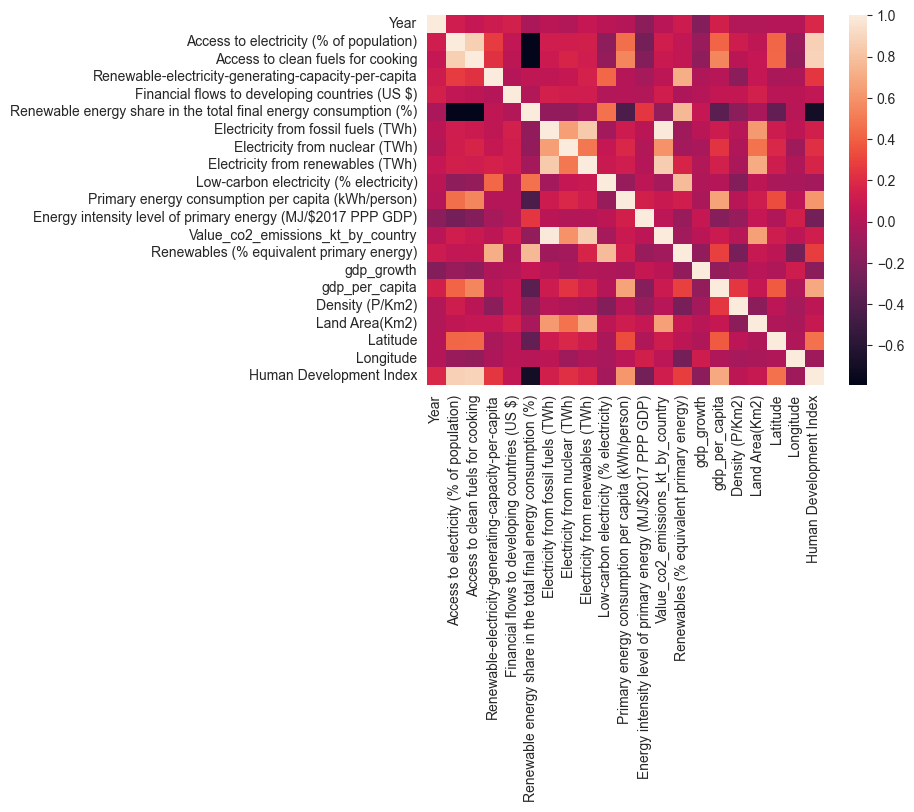

In [161]:

cor = df_energy.drop(columns=categorical_columns).corr()
sn.heatmap(cor)

### Easy map with go.Choropleth()

In [162]:
year = 2012
column_name = "Human Development Index"

fig = go.Figure()

filtered_df = df_energy[df_energy['Year'] == year]


trace = go.Choropleth(
            locations=filtered_df['Entity'],
            z=filtered_df[column_name],
            locationmode='country names',
            colorscale='viridis',  # Use a different color scale for better contrast
            colorbar=dict(title=column_name),
            zmin=df_energy[column_name].min(),
            zmax=df_energy[column_name].max(),
)

fig.add_trace(trace)

fig.update_layout(
    title_text=f'{column_name} Map with slider',  # Set the initial title
    title_font_size=24,  # Increase title font size
    title_x=0.5,  # Center the title
    height=800,  # Set the height of the figure in pixels
    width=1000,  # Set the width of the figure in pixels
    font=dict(family='Arial', size=12),  # Customize font family and size for the whole figure
    margin=dict(t=80, l=50, r=50, b=50),  # Add margin for better layout spacing
    # Change the template to 'plotly_dark'
)


fig.show()

In [163]:
geodata = gpd.read_file(path_geodata)

In [177]:
def histo_HDI(df_histo : pd.DataFrame = df_energy, area_type : str = "Continent", area_name : str = "Europe", year : int = 2000, reference_name : str = "France", reference_year : int = 2015) -> go.Figure :
    """
    histo_HDI make a histogram with the frequency of HDI for a given area type. The slider change the year of observation. The area name is the current country observed.
    :param reference_year: 
    :param reference_name: 
    :param df_histo: 
    :param area_type: 
    :param area_name: 
    :param year: 
    :return: 
    """
    
    # Selection feature needed
    df_histo = pd.DataFrame(data=df_histo, columns=['Year', 'Entity', 'Continent', 'Region', 'Human Development Index'])
    
    # Filtering by the area_name and the year + the reference year for this same are_name
    df_histo_filtered = df_histo.query(f"({area_type} == '{area_name}') and (Year == {year} or Year == {reference_year})")

    # Creation of the feature 'reference' that is a boolean.
    df_histo_filtered['reference'] = df_histo_filtered['Year'] == reference_year
    

    # assert (df_histo_filtered['reference'] == True).sum() == (df_histo_filtered['reference'] == False).sum(), "<-- Some data are missing -->"
    
    fig = px.histogram(df_histo_filtered, 
                       x="Human Development Index", 
                       marginal="box",  #["rug", "box", "violin"]
                       color="reference",   
                       title='Histogram Human Development Index per year with 2020 as reference',
                       pattern_shape="reference",
                       opacity=1,
                       template=THEME,
                       text_auto=True
                       ) 
    fig.show()
    
    print(f"La somme des True = {(df_histo_filtered['reference'] == True).sum()} et la somme des False = {(df_histo_filtered['reference'] == False).sum()} ")

    return df_histo_filtered

histo_HDI()

C:\Users\antoi\AppData\Local\Temp\ipykernel_8588\2377466746.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



La somme des True = 37 et la somme des False = 35 


,Year,Entity,Continent,Region,Human Development Index,reference
21,2000,Albania,Europe,Southern Europe,0.677,False
36,2015,Albania,Europe,Southern Europe,0.795,True
189,2000,Austria,Europe,Western Europe,0.871,False
204,2015,Austria,Europe,Western Europe,0.910,True
315,2000,Belarus,Europe,Eastern Europe,0.712,False
...,...,...,...,...,...,...
3223,2015,Switzerland,Europe,Western Europe,0.954,True
3439,2000,Ukraine,Europe,Eastern Europe,0.700,False
3454,2015,Ukraine,Europe,Eastern Europe,0.774,True
3481,2000,United Kingdom,Europe,Northern Europe,0.862,False


In [44]:
fig = px.histogram(
    data_frame=df_energy,
    x="Year",
    y="Electricity from fossil fuels (TWh)",
    color="Continent",
    template=THEME,
    barmode="group",

)

fig.show()

In [81]:
fig = make_subplots(rows=3, cols=1, subplot_titles=["Fossil fuels","Nuclear","Renewable"], shared_xaxes=True, vertical_spacing=0.1)

trace1 = px.histogram(
    data_frame=df_energy,
    x="Year",
    y="Electricity from fossil fuels (TWh)",
    # color="Continent",
    template=THEME,
    color_discrete_sequence=["red"],
    opacity=0.7,
)

trace2 = px.histogram(
    data_frame=df_energy,
    x="Year",
    y="Electricity from nuclear (TWh)",
    # color="Continent",
    color_discrete_sequence=["orange"],
    opacity=0.7,
    template=THEME,
)

trace3 = px.histogram(
    data_frame=df_energy,
    x="Year",
    y="Electricity from renewables (TWh)",
    # color="Continent",
    color_discrete_sequence=["green"],
    opacity=0.7,

    template=THEME,
)
fig.add_trace(trace1.data[0], row=1, col=1)
fig.add_trace(trace2.data[0], row=2, col=1)
fig.add_trace(trace3.data[0], row=3, col=1)
# fig.add_traces([trace1["data"],trace2,trace3])

for trace in trace1.data:
    fig.add_trace(trace, row=1, col=1)

for trace in trace2.data:
    fig.add_trace(trace, row=2, col=1)

for trace in trace3.data:
    fig.add_trace(trace, row=3, col=1)


fig.update_yaxes(range=[0, 15000], row=1, col=1)
fig.update_yaxes(range=[0, 15000], row=2, col=1)
fig.update_yaxes(range=[0, 15000], row=3, col=1)
fig.update_layout(height = 800)

fig.show()